torch.Size([100, 3])
            MFGLib v0.1.1 : A Library for Mean-Field Games             
                  (c) RADAR Research Lab, UC Berkeley                  

Environment summary:
	S=(100,)
	A(3,)
	T=15
	r_max=100

Algorithm summary:
	FictitiousPlay(alpha=None)
	atol=1e-05
	rtol=1e-05
	max_iter=5000

-----------------------------------------------------------------------
| iter |  expl_n  | expl_n / expl_0 | argmin_{0..n} expl_i | time (s) |
-----------------------------------------------------------------------
|  0   | 4.59515  |     1.00000     |          0           |  0.000   |
|  0   | 4.59515  |     1.00000     |          0           |  0.000   |
|  1   | 48.34669 |    10.52125     |          0           |  0.014   |
|  2   | 10.58086 |     2.30262     |          0           |  0.025   |
|  3   | 13.46455 |     2.93017     |          0           |  0.034   |
|  4   | 10.85766 |     2.36285     |          0           |  0.044   |
|  5   | 8.12916  |     1.76908     |      

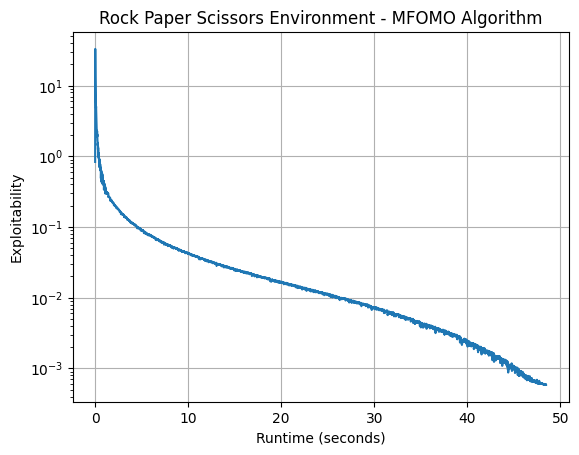

In [5]:
from mfglib.env import Environment
from mfglib.alg import MFOMO,PriorDescent, AIDFictitiousPlay,FictitiousPlay
from mfglib.metrics import exploitability_score
import matplotlib.pyplot as plt
from mfglib.mean_field import mean_field
import torch
from mfglib.alg.greedy_policy_given_mean_field import Greedy_Policy

# instance = Environment.susceptible_infected(T=15)
# instance = Environment.bottleneck(inertia=0, M=60, T=2)
instance = Environment.beach_bar(n=100, bar_loc=50, T=15)
# instance = Environment.rock_paper_scissors(T=15)

# Run the MF-OMO algorithm with default hyperparameters and default tolerances and plot exploitability scores
#solns, expls, runtimes = PriorDescent(eta=1, n_inner=1, update_initial=True).solve(instance, max_iter=3000, verbose=True)
solns, expls, runtimes = FictitiousPlay(update_initial=True).solve(instance, max_iter=5000, verbose=True)

plt.semilogy(runtimes, exploitability_score(instance, solns)) 
plt.grid(True)
plt.xlabel("Runtime (seconds)")
plt.ylabel("Exploitability")
plt.title("Rock Paper Scissors Environment - MFOMO Algorithm")
plt.show()

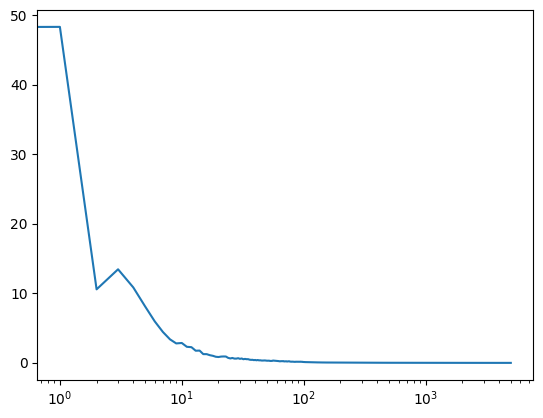

In [6]:
plt.plot(expls)
plt.xscale('log')

In [7]:
pi = solns[-1]
L = mean_field(instance, pi)
mu = torch.sum(L, axis=2)


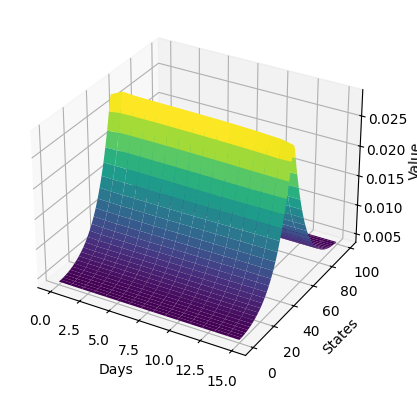

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

mu_np = mu.numpy()

# Create meshgrid for X (days) and Y (states)
days = np.arange(mu.shape[0])  # [0, 1, 2]
states = np.arange(mu.shape[1])  # [0, 1, 2, 3]
X, Y = np.meshgrid(days, states, indexing='ij')  # Use 'ij' to align correctly

# Plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Surface plot
surf = ax.plot_surface(X, Y, mu_np, cmap='viridis')

# Labels
ax.set_xlabel("Days")
ax.set_ylabel("States")
ax.set_zlabel("Value")

plt.show()

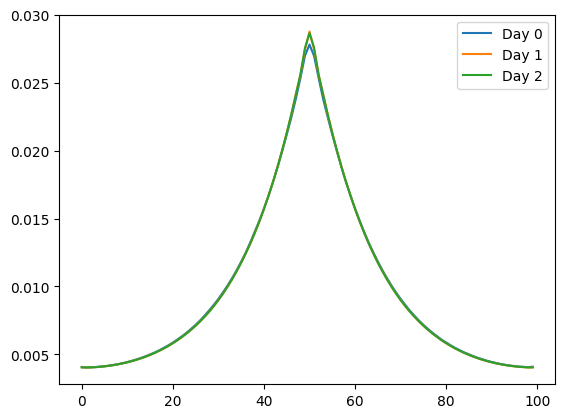

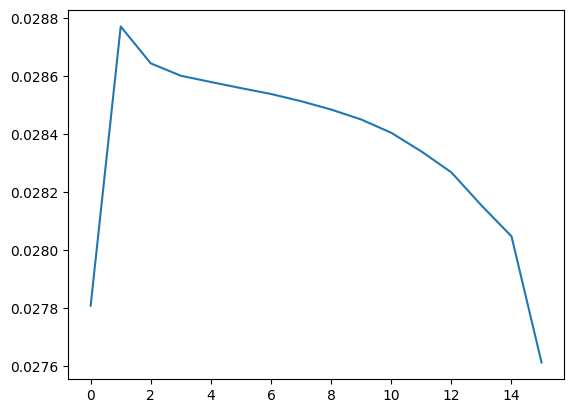

In [9]:
for day in range(3):
    plt.plot(mu[day, :], label=f"Day {day}")
plt.legend()
plt.show()
plt.plot(mu[:, 50])

### Test terminal reward

In [10]:
from mfglib.alg.q_fn import QFn

T = instance.T
print(L[T])
q_values = torch.empty(size=(T + 1, *instance.S, *instance.A))
q_values[T] = instance.reward(T, L[T])
print(q_values[T])

Q_s_L = QFn(instance, L).optimal()

instance_terminal = Environment.beach_bar_terminal(n=3, bar_loc=1, T=3)
q_values = torch.empty(size=(T + 1, *instance.S, *instance.A))
q_values[T] = instance_terminal.reward(T, L[T])
print(q_values[T])

tensor([[0.0000, 0.0041, 0.0000],
        [0.0000, 0.0041, 0.0000],
        [0.0000, 0.0041, 0.0000],
        [0.0000, 0.0041, 0.0000],
        [0.0000, 0.0041, 0.0000],
        [0.0000, 0.0041, 0.0000],
        [0.0000, 0.0042, 0.0000],
        [0.0000, 0.0042, 0.0000],
        [0.0000, 0.0043, 0.0000],
        [0.0000, 0.0044, 0.0000],
        [0.0000, 0.0044, 0.0000],
        [0.0000, 0.0045, 0.0000],
        [0.0000, 0.0046, 0.0000],
        [0.0000, 0.0047, 0.0000],
        [0.0000, 0.0049, 0.0000],
        [0.0000, 0.0050, 0.0000],
        [0.0000, 0.0051, 0.0000],
        [0.0000, 0.0053, 0.0000],
        [0.0000, 0.0055, 0.0000],
        [0.0000, 0.0057, 0.0000],
        [0.0000, 0.0059, 0.0000],
        [0.0000, 0.0061, 0.0000],
        [0.0000, 0.0063, 0.0000],
        [0.0000, 0.0066, 0.0000],
        [0.0000, 0.0069, 0.0000],
        [0.0000, 0.0072, 0.0000],
        [0.0000, 0.0075, 0.0000],
        [0.0000, 0.0079, 0.0000],
        [0.0000, 0.0082, 0.0000],
        [0.000

RuntimeError: The size of tensor a (3) must match the size of tensor b (100) at non-singleton dimension 0

### Bottleneck test

In [101]:
def T_vectorized(mu: torch.Tensor) -> torch.Tensor:
        """
        Compute T(s, mu) for each state s in a vectorized way.
        mu is a tensor of shape (M,).
        """
        M = mu.shape[0]
        indices = torch.arange(M, dtype=torch.float32)
        # Compute the temporary array: inflow * mu / Cap.
        temp = 6000 * mu / 3000
        # Cumulative sum adjusted by the time step.
        sum_record = torch.cumsum(temp, dim=0) - 3/40 * indices
        # Compute the running minimum.
        min_record, _ = torch.cummin(sum_record, dim=0)
        return sum_record - min_record  # shape: (M,)

def f_vectorized(mu: torch.Tensor) -> torch.Tensor:
    """
    Compute f(s, mu) for each state s.
    Returns a tensor of shape (M,).
    """
    M = mu.shape[0]
    s_vals = torch.arange(M, dtype=torch.float32)
    T_vals = T_vectorized(mu)  # shape: (M,)
    # Compute the threshold: r - s*dt - T(s, mu)
    threshold = 2 - s_vals * 3/40 - T_vals
    # Use torch.where for the piecewise definition.
    f_vals = 10 * T_vals + torch.where(
        threshold > 0,
        5 * threshold,
        15 * (-threshold)
    )
    return f_vals  # shape: (M,)

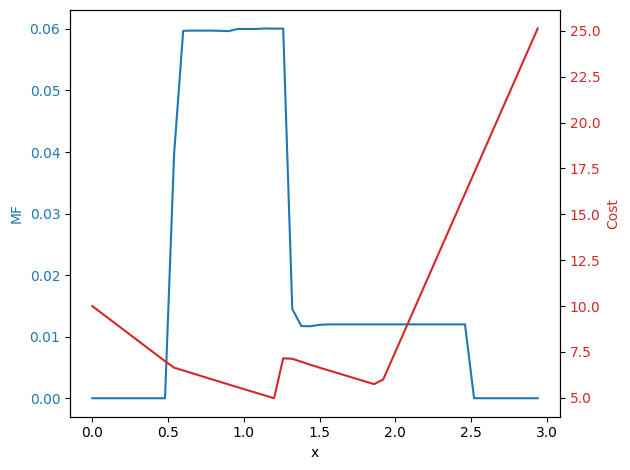

In [96]:
x = np.arange(50) * 3/50
y1 = mu[-1]
y2 = f_vectorized(y1)
fig, ax1 = plt.subplots()

# Plot the first curve on ax1
color = 'tab:blue'
ax1.set_xlabel('x')
ax1.set_ylabel('MF', color=color)
ax1.plot(x, y1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a secondary y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot the second curve on ax2
color = 'tab:red'
ax2.set_ylabel('Cost', color=color)
ax2.plot(x, y2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Adjust layout so labels do not overlap
fig.tight_layout()

plt.show()
